In [226]:
import torch.nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import glob
import time
import os
import unicodedata

### RNN

In [227]:
# # FOR ab
# HIDDEN_SIZE = 16
# BATCH_SIZE = 100
# N_LAYER = 1
# N_EPOCHS = 60
# N_CHARS = 128
# USE_GPU = False
# learning_rate = 0.005
# # For abc
# HIDDEN_SIZE = 32
# BATCH_SIZE = 200
# N_LAYER = 1
# N_EPOCHS = 22
# N_CHARS = 128
# USE_GPU = False
# learning_rate = 0.0001

### LSTM

In [228]:
# # FOR ab
# HIDDEN_SIZE = 64
# BATCH_SIZE = 100
# N_LAYER = 1
# N_EPOCHS = 7
# N_CHARS = 128
# USE_GPU = False
# learning_rate = 0.01
# For abc
HIDDEN_SIZE = 64
BATCH_SIZE = 100
N_LAYER = 1
N_EPOCHS = 10
N_CHARS = 128
USE_GPU = False
learning_rate = 0.05

In [229]:
class CharsDataset(Dataset):
    def __init__(self, is_train_set=True):
        self.all_letters = "abc"
        self.filenames = f'./data/{self.all_letters}train/*.txt' if is_train_set else f'./data/{self.all_letters}test/*.txt'
        self.category_lines = {"0":[],"1":[]}
        self.all_categories = []
        self.lines = []
        for filename in glob.glob(self.filenames):
            category = os.path.splitext(os.path.basename(filename))[0]
            self.all_categories.append(category)
            lines = self.readLines(filename)
            # for val_length in val_lengths:
            #     val_lines = list(filter(lambda s: len(s) == val_length, lines))
            #     # self.category_validation_lines[category] += val_lines
            # train_lines = [tl for tl in lines if tl not in self.category_validation_lines[category]]
            self.category_lines[category] = lines
            self.lines += lines
        self.len = len(self.lines)

    def __getitem__(self, index):
        item = self.category_lines[str(index%len(self.all_categories))][index // len(self.all_categories)]
        label_index = int(list(self.category_lines.keys())[index%len(self.all_categories)])
        return item, label_index 

    def __len__(self):
        return self.len

    def unicodeToAscii(self, s):
        lines = ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in self.all_letters
        )
        return lines

    def readLines(self, filename):
        lines = open(filename, encoding='utf-8').read().strip().split('\n')
        return [self.unicodeToAscii(line) for line in lines]

    def get_categorires_num(self):
        return len(self.all_categories)

In [230]:
trainset = CharsDataset(is_train_set=True)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
N_LABELS = trainset.get_categorires_num()

testset = CharsDataset(is_train_set=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [231]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=False):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1

        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.rnn = torch.nn.RNN(hidden_size, hidden_size, n_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size*self.n_directions, output_size)

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers*self.n_directions, batch_size, self.hidden_size)
        return create_tensor(hidden)

    def forward(self, input, seq_lengths):
        input = input.t()  # input.shape:BxS->SxB
        batch_size = input.size(1)

        hidden = self._init_hidden(batch_size)
        embedding = self.embedding(input)

        # pack them up
        rnn_input = pack_padded_sequence(embedding, seq_lengths)

        output , hidden = self.rnn(rnn_input, hidden)
        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]
        return self.fc(hidden_cat)

In [232]:
class LSTMClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.lstm = torch.nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size*self.n_directions, output_size)

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers*self.n_directions, batch_size, self.hidden_size)
        return create_tensor(hidden)

    def forward(self, input, seq_lengths):
        input = input.t()  # input.shape:BxS->SxB
        batch_size = input.size(1)

        hidden = self._init_hidden(batch_size)
        c0 = self._init_hidden(batch_size)
        embedding = self.embedding(input)

        # pack them up
        lstm_input = pack_padded_sequence(embedding, seq_lengths)

        lstm_output , (hidden, ct) = self.lstm(lstm_input, (hidden, c0))
        return self.fc(hidden[-1])

In [233]:
# classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_LABELS, N_LAYER)

classifier = LSTMClassifier(N_CHARS, HIDDEN_SIZE, N_LABELS, N_LAYER)

if USE_GPU:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    classifier.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

In [234]:
# convert name to tensor
def create_tensor(tensor):
    if USE_GPU:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        tensor = tensor.to(device)
    return tensor

def line2list(line):
    arr = [ord(c) for c in line]
    return arr, len(arr)

def make_tensors(lines, labels):
    sequences_and_lengths = [line2list(line) for line in lines]
    chars_sequences = [sl[0] for sl in sequences_and_lengths]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths])
    
    labels = labels.long()

    # make tensor of name, Batchsize x Seqlen, padding
    seq_tensor = torch.zeros(len(chars_sequences), seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(chars_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # sort by length to use pack_padded_sequence
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[perm_idx]
    labels = labels[perm_idx]

    return create_tensor(seq_tensor), create_tensor(seq_lengths), create_tensor(labels)

In [235]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [236]:
def grad_clipping(net, theta):
    """grad_clipping"""
    if isinstance(net, torch.nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [237]:
def trainModel():
    classifier.train()
    total_loss = 0.0
    for i, (lines, labels) in enumerate(trainloader, 1):
        inputs, seq_lengths, target = make_tensors(lines, labels)
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        grad_clipping(classifier, 1)
        optimizer.step()
        total_loss += loss.item()
    loss_save.append(total_loss / len(trainset))
    print(f'[{time_since(start)}] Epoch {epoch} , loss={total_loss / len(trainset)}')


In [238]:
def predictModel():
    acc_dict = {i: torch.zeros(N_LABELS, N_LABELS) for i in range(21, 51)}
    correct = 0
    total = len(testset)
    print('evaluating tarined model ...')
    classifier.eval()
    with torch.no_grad():
        for i, (lines, labels) in enumerate(testloader, 1):
            inputs, seq_lengths, target = make_tensors(lines, labels)
            test_length = np.count_nonzero(inputs, axis=1)
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i, key in enumerate(test_length):
                acc_dict[key][target[i]][pred[i]] += 1
        for i in range(21, 51):
            acc = (acc_dict[i][0][0] + acc_dict[i][1][1]) / acc_dict[i].sum()
            print(f"length: {i} and accuracy is {acc}")
        
        percent = '%.2f' % (100*correct/total)
        print(f'Test set: Accuracy {correct}/{total} {percent}%')

    return acc_dict


Trainin for 10 epochs....
 1s] Epoch 1 , loss=0.0037567878844216467
 2s] Epoch 2 , loss=0.0001329926607257221
 3s] Epoch 3 , loss=1.199590184551198e-05
 4s] Epoch 4 , loss=5.93155733513413e-06
 5s] Epoch 5 , loss=2.5064163921342696e-06
 6s] Epoch 6 , loss=1.3681934338819702e-06
 8s] Epoch 7 , loss=9.011031983391149e-07
 9s] Epoch 8 , loss=6.497006193967536e-07
 10s] Epoch 9 , loss=5.051642843682202e-07
 11s] Epoch 10 , loss=4.0460628133587305e-07
evaluating tarined model ...
length: 21 and accuracy is 1.0
length: 22 and accuracy is 1.0
length: 23 and accuracy is 1.0
length: 24 and accuracy is 1.0
length: 25 and accuracy is 1.0
length: 26 and accuracy is 1.0
length: 27 and accuracy is 1.0
length: 28 and accuracy is 1.0
length: 29 and accuracy is 1.0
length: 30 and accuracy is 1.0
length: 31 and accuracy is 1.0
length: 32 and accuracy is 1.0
length: 33 and accuracy is 1.0
length: 34 and accuracy is 1.0
length: 35 and accuracy is 1.0
length: 36 and accuracy is 1.0
length: 37 and accuracy 

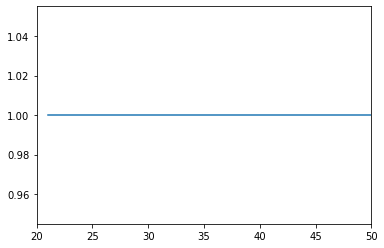

In [239]:
start = time.time()
print('Trainin for %d epochs....' % N_EPOCHS)

loss_save = []
for epoch in range(1, N_EPOCHS+1):
    trainModel()

acc_dict=predictModel()

acc = [(acc_dict[i][0][0] + acc_dict[i][1][1]) / acc_dict[i].sum() for i in range(21, 51)]
plt.xlim(20,50)
plt.plot(np.arange(21,51), acc)


In [240]:
for i in range(21,51):
    print(i, acc_dict[i])
# acc = [(_acc_check[i][0][0] + _acc_check[i][1][1]) / _acc_check[i].sum() for i in range(21, 51)]
# plt.plot(np.arange(21,51), acc)
# # plt.ylim(0.8, 1.05)
# plt.xlim(20,50)

21 tensor([[100.,   0.],
        [  0., 300.]])
22 tensor([[100.,   0.],
        [  0.,   0.]])
23 tensor([[100.,   0.],
        [  0.,   0.]])
24 tensor([[100.,   0.],
        [  0., 300.]])
25 tensor([[100.,   0.],
        [  0.,   0.]])
26 tensor([[100.,   0.],
        [  0.,   0.]])
27 tensor([[100.,   0.],
        [  0., 300.]])
28 tensor([[100.,   0.],
        [  0.,   0.]])
29 tensor([[100.,   0.],
        [  0.,   0.]])
30 tensor([[100.,   0.],
        [  0., 300.]])
31 tensor([[100.,   0.],
        [  0.,   0.]])
32 tensor([[100.,   0.],
        [  0.,   0.]])
33 tensor([[100.,   0.],
        [  0., 300.]])
34 tensor([[100.,   0.],
        [  0.,   0.]])
35 tensor([[100.,   0.],
        [  0.,   0.]])
36 tensor([[100.,   0.],
        [  0., 300.]])
37 tensor([[100.,   0.],
        [  0.,   0.]])
38 tensor([[100.,   0.],
        [  0.,   0.]])
39 tensor([[100.,   0.],
        [  0., 300.]])
40 tensor([[100.,   0.],
        [  0.,   0.]])
41 tensor([[100.,   0.],
        [  0., 